## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2022-12-30 15:39:27--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-12-30 15:39:28 ERROR 404: Not Found.



FileNotFoundError: ignored

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

### Data loading: "Евгений Онегин"


In [3]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding = 'utf-8') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]
text = [x.replace('\n', '') for x in text]
lines = [x.lower() for x in text]

--2022-12-30 15:39:31--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.003s  

2022-12-30 15:39:32 (90.8 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
out = [text[i] for i in range(len(text))]
tokens = sorted(set(out + ['_', '<', '>']))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from IPython import display
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

In [7]:
# dict <index>:<char>
# Your great code here
num_tokens = len(tokens)
ohe = np.eye(num_tokens)
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
token_to_ohe = {token: ohe[idx] for idx, token in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(token_to_idx.keys())}

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), rnn_num_units=64, rnn_type='rnn'):
        super(self.__class__,self).__init__()
        assert rnn_type in ['rnn','lstm']
        self.num_units = rnn_num_units
        rnn_args = (num_tokens, rnn_num_units, 1,)
        self.rnn = nn.RNN(*rnn_args, batch_first = True) if rnn_type == 'rnn' else nn.LSTM(*rnn_args, batch_first = True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev = None):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        output, h_next = self.rnn(x, h_prev)
        
        logits = self.rnn_to_logits(output) 
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [10]:
def to_matrix(names, max_len=None, pad=token_to_idx['_'], dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    max_len += 1
    names_ix = np.zeros([len(names), max_len], dtype) + pad
    names_ix[:, 0] = token_to_idx['<'] # <SOS>

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        names_ix[i, 1:len(line_ix)] = line_ix[1:]
        names_ix[i, len(line_ix)] = token_to_idx['>'] # <EOS>

        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

def to_ohe_matrix(lines, max_len=None, pad=token_to_ohe['_'], dtype='int32', batch_first=True):
    
    max_len = max_len or max(map(len, lines))
    max_len += 1
    names_ix = np.zeros((len(lines), max_len, num_tokens), dtype) + pad
    names_ix[:, 0, :] = token_to_ohe['<'] # <SOS>

    for i in range(len(lines)):
        line_ix = [token_to_ohe[c] for c in lines[i]] # (L, num_tokens)
        line_ix = np.array(line_ix)
        names_ix[i, 1:len(line_ix),:] = line_ix[1:, :]
        names_ix[i, len(line_ix), :] = token_to_ohe['>'] # <EOS>

        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix


In [29]:
'abc'[:-1]

'ab'

In [72]:
def get_next_x(p_next):
  next_idx = np.random.choice(num_tokens, p=p_next[-1])
  next_token = idx_to_token[next_idx]
  x = torch.tensor(token_to_ohe[next_token], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
  return x.to(device), next_token

def generate_text(net, max_len = 400, seed_phrase='<', temperature=1.0):
    generated_text = [seed_phrase]
    h = None
    for char in seed_phrase:
      x = torch.tensor(token_to_ohe[char], dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(0)
      h, logits = net(x, h)
    p_next = F.softmax(logits / temperature, dim=-1).detach().cpu().numpy()[0]
    x, next_token = get_next_x(p_next)
    generated_text.append(next_token)
    for _ in range(max_len - len(seed_phrase)):
        h, logits = net(x, h)
        p_next = F.softmax(logits / temperature, dim=-1).detach().cpu().numpy()[0]
        x, next_token = get_next_x(p_next)
        #x = torch.cat([x, next_x], dim = 1)
        generated_text.append(next_token)
    return ''.join(generated_text)

In [ ]:
char_rnn = CharRNNCell().to(device)
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=torch.tensor(token_to_idx['_']))

history = []
context_width = 200
text_size = len(text)
batch_size = 128

In [ ]:
epochs = 10

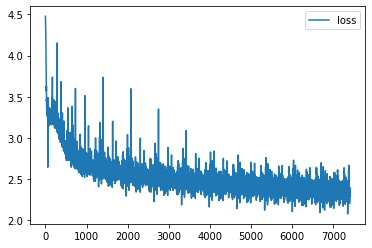

In [ ]:
# Your plot code here
for e in range(epochs):
  for i in range(0, text_size - context_width, context_width):
      batch_text = [text[i+j:i+j+context_width] for j in range(context_width)]
  #     batch_text = sample(f_text, 128)
      target = torch.tensor(to_matrix(batch_text), dtype=torch.int64)[:, 1:].to(device)
      #print(target.shape)
      batch_ix = to_ohe_matrix(batch_text, max_len=context_width)[:, :-1, :]
      batch_ix = torch.tensor(batch_ix, dtype=torch.float32).to(device)
      
      h, logits_seq = char_rnn(batch_ix)
      loss = loss_func(logits_seq.permute(0, 2, 1), target)
      
      #loss_func(logits_seq, batch_ix)
      
      loss.backward()
      opt.step()
      
      opt.zero_grad()
      
      history.append(loss.detach().cpu().numpy())
      if i%1000 == 0:
          display.clear_output(True)
          print(f'Current epoch: {e}')
          plt.plot(history,label='loss')
          plt.legend()
          plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

In [ ]:
generate_text(char_rnn, temperature=0.2)

'ен постали на сталинный в сердце в сердце продом не страки в сердце в сердце в постали приздало на посталить мого в свето в деренный постали постраний соной на следать на света в замен подной он безд'

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [12]:
char_rnn = CharRNNCell(rnn_type = 'lstm').to(device)
opt = torch.optim.Adam(char_rnn.parameters(), 3e-3)
loss_func = nn.CrossEntropyLoss(ignore_index=torch.tensor(token_to_idx['_']))

history = []
context_width = 200
text_size = len(text)
batch_size = 128
epochs = 10

Current epoch: 9


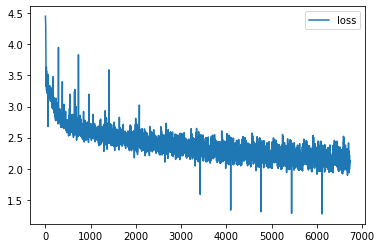

In [13]:
# Your plot code here
for e in range(epochs):
  for i in range(0, text_size - context_width, context_width):
      batch_text = [text[i+j:i+j+context_width] for j in range(context_width)]
  #     batch_text = sample(f_text, 128)
      target = torch.tensor(to_matrix(batch_text), dtype=torch.int64)[:, 1:].to(device)
      #print(target.shape)
      batch_ix = to_ohe_matrix(batch_text, max_len=context_width)[:, :-1, :]
      batch_ix = torch.tensor(batch_ix, dtype=torch.float32).to(device)
      
      h, logits_seq = char_rnn(batch_ix)
      loss = loss_func(logits_seq.permute(0, 2, 1), target)
      
      #loss_func(logits_seq, batch_ix)
      
      loss.backward()
      opt.step()
      
      opt.zero_grad()
      
      history.append(loss.detach().cpu().numpy())
      if i%1000 == 0:
          display.clear_output(True)
          print(f'Current epoch: {e}')
          plt.plot(history,label='loss')
          plt.legend()
          plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [47]:
char_rnn.eval()

CharRNNCell(
  (rnn): LSTM(85, 64, batch_first=True)
  (rnn_to_logits): Linear(in_features=64, out_features=85, bias=True)
)

In [73]:
# Text generation with different temperature values here
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
  text = generate_text(char_rnn, seed_phrase = 'люблю', temperature=t)
  print(f'Temperature: {t}')
  print(f'Text:\n{text}')

Temperature: 0.1
Text:
люблю в света в сердце в сердце в сердце в сердце в с ней не страсть он не странный в собранный постали в с нем он не странный в том он не странный в собранный в с была на своей странный в сердце так не все в странный в страсть он не приводит он он глуши в сердце в сердце в сердце так на старанный в сердце в сердце в сердце в с ней не странный в том он не странной странный в сердце в страсть в с не
Temperature: 0.2
Text:
люблю в сердце странной в с была в своей странный в смердым в молчала в проходит постой постень он не встренье, прости мой так на приводной молодной все в ней простить не приздала в страсть он он не встал он в с ней как подушный в собранной не своей не вам он со видам своей тами молодной поразаним одна, постой странной в своей посту не страсть он глядит сердце в сердце в с ней не странный в могом в
Temperature: 0.5
Text:
люблю в с нем устанье в том на простия мельной как рукой ках, вас быть онегин мол дам визна вседно на все их разговор он гласти

Как можно понять, чем больше temperature тем менее связные тексты. Если полагаться на те вероятности, которые выдаёт модель, то можно заметить, что модель пораждает много несвязных слов. При этом в хороших сэмплах довольно часто повторяются слова. Возможно, данного значения лосс функции мало и нужно поиграть с лернинг рейтами, schedulerами и увеличением эпох

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [55]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [60]:
path = '/content/drive/MyDrive/PoetryLSTM.pt'

In [65]:
# Saving and loading code here
save_dict = {}
save_dict['opt_state'] = opt
save_dict['model_state'] = char_rnn  
torch.save(save_dict, path)
state_dict = torch.load(path)
poet_lstm = state_dict['model_state']

In [77]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
  text = generate_text(poet_lstm, seed_phrase = 'наташа', temperature=t)
  print(f'Temperature: {t}')
  print(f'Text:\n{text}')

Temperature: 0.1
Text:
наташа не прости молодной в страсть он не странный в своей постали в с ней не страсть он в с ней не странный в странной в странный в странный в сердце в сердце в сердце в сердце в сердце прости молодной в сердце в сердце так не восной постой странный в сердце в сердце в сердце в сердце в сердце в сердце в сердце в сердце в сердце странный постели в с ней не странный в собранный в с была в странный 
Temperature: 0.2
Text:
наташа в сердце там и в собранный в том он был с нем он он не встал в страсть он глядать на старить он странной в страсть он глада странный постой признали в с нем он не все в собранной не страсть он не приводит он страсть он глуши в с нем он страсть в сердце в странный в том молодной в ней страсть он не странной не странный в том он не всех странный в сердце не прости мой построй, приводит собранн
Temperature: 0.5
Text:
наташа не так сердце так то на привым он не мой страсть молодный не страшный маловает слави моей, и видал сердцам в сами без и 

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)